Interacting with manifold
====================
The basic interface of _StochMan_ is that you first define a manifold, and then use this to compute geodesics, etc. The manifold objects will generally depend on data as the focus of _StochMan_ is on _learning manifolds_. As a first simple example of how to engage with manifolds once they have been constructed. We therefore start with with a pre-implemented manifold that correspond to the paper:

_A Locally Adaptive Normal Distribution_  
Georgios Arvanitidis, Lars Kai Hansen, and Søren Hauberg.  
Neural Information Processing Systems (NeurIPS), 2016.  

Here the observation space is endowed with a Riemannian metric which is simply the inverse covariance of data computed locally.

To get started we import relevant modules

In [1]:
#!/usr/bin/env python3
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import torchplot as plt
from torchvision.datasets import MNIST
from sklearn.decomposition import PCA

import stochman

We'll be using MNIST as a toy example to get started. We select 1000 observations of one-digits and perform PCA to get a two-dimensional representation. We do this to ensure that we can visualize the results.

In [2]:
def get_subset_mnist(n: int = 1000):
    dataset = MNIST(root="", download=True)
    idx_ones = dataset.targets == 1
    mnist_ones = dataset.data[idx_ones].to(torch.float32)
    N = mnist_ones.shape[0]
    idx = torch.randint(N, [n,])
    data = mnist_ones[idx].reshape(n, -1).numpy()
    low_dim_data = torch.from_numpy(PCA(n_components=2).fit_transform(data))
    return low_dim_data / low_dim_data.std(dim=0, keepdim=True)

# Read data
data = get_subset_mnist(n=1000)
data = data
N, D = data.shape

Next we construct the manifold using the predefined _LocalVarMetric_ class.

In [3]:
# Parameters for metric
sigma = 0.1
rho = 0.1

# Create metric
M = stochman.manifold.LocalVarMetric(data=data, sigma=sigma, rho=rho)

We now have a manifold to play around with. As a starting point, we will evaluate the volume measure (sometimes also called to _magnification_ _factor_ associated with the manifold in order to visualize the data and the metric.

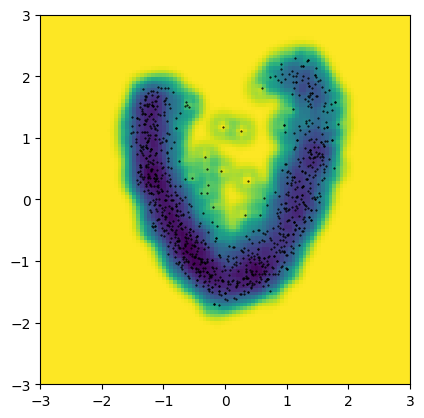

In [4]:
# Plot metric and data
with torch.no_grad():
    ran = torch.linspace(-3., 3., 100)
    gridX, gridY = torch.meshgrid([ran, ran], indexing="ij")
    grid = torch.stack((gridX.flatten(), gridY.flatten()), dim=1)  # 10000x2
    magfac = M.log_volume(grid)  # 10000
plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), "k.", markersize=1)

[[<matplotlib.lines.Line2D at 0x7f4ccf231840>],

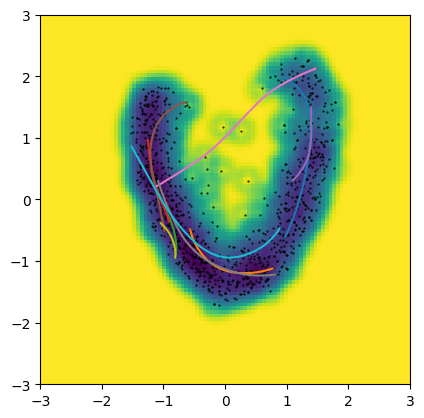

In [5]:
# Compute geodesics in parallel
p0 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
p1 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
C, success = M.connecting_geodesic(p0, p1)
plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), "k.", markersize=1)
C.plot()

[[<matplotlib.lines.Line2D at 0x7f4ccf2e4490>]]

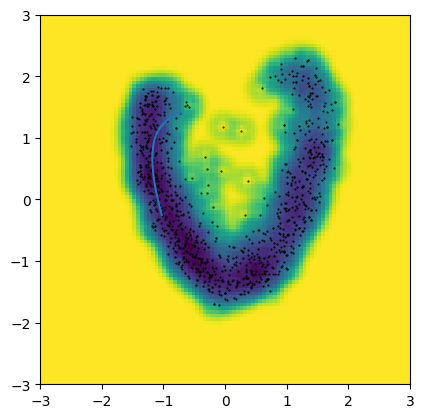

In [6]:
# Compute shooting geodesic as a sanity check
p0 = data[0]  # 1xD
p1 = data[1]  # 1xD
C, success = M.connecting_geodesic(p0, p1)
plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), "k.", markersize=1)
C.plot()